# Part 1: How to get data on player projections
___________

### Overview
What makes daily fantasy sports (DFS) so unique in comparison to traditional fantasy sports is that you can (1) play every single day and (2) create any number of different lineups as long as you fill the required positions and stay under the salary cap. This makes for a virtually unlimited number of different lineup combinations. In order to truly optimize your lineups you need to have accurate projections of how each player is *expected* to perform. 

One of the pieces of data that I wanted to include in my Daily Fantasy Sports database was information on player projections. I was specifically looking for data on the number of points each player was *projected* to score for a given week.

After doing some research I was able to find weekly projection data on [Rotogrinders](http://rotogrinders.com/projected-stats/nfl-flex?site=draftkings). The website offers a subscription service where they provide tools and loads of statistics on players and matchups. For non-subscribers they do offer projection data, although limited, still gives me what I need.

You can get weekly projection data on every position:

- QB
- RB
- WR
- TE
- Flex
- Defense
- Kicker

For the purposes of this project I'm going to show you how to pull projection data from this site and then do some cleaning and exploratory data analysis.

## 1a: Getting the data

Looking at their site you can see they have a nice table with lots of data about the player and their projected output. You can see the information for non-subscribers is hidden, but that still leaves us with the data I originally wanted: **projected points**.

You can see they offer this data as a flat file.

If you click on **QB** and then right-click on the *Download as CSV* button, we can inspect the URL:

`https://rotogrinders.com/projected-stats/nfl-qb.csv?site=draftkings`

I did the same thing with the other positions to verify that the links were constructed the same way. The only difference is that the link changes for each position you click. Now we can grab the data for each position and combine them into a single list.

In [15]:
#Import necessary libraries
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#We're going to export this to a new .csv file later: file_name
file_name = 'player_projections_'
timestr = time.strftime("%d%m%Y")

#Create a list that holds every URL we want data for: url
url = ['https://rotogrinders.com/projected-stats/nfl-qb.csv?site=draftkings',\
      'https://rotogrinders.com/projected-stats/nfl-rb.csv?site=draftkings',\
      'https://rotogrinders.com/projected-stats/nfl-wr.csv?site=draftkings',\
      'https://rotogrinders.com/projected-stats/nfl-te.csv?site=draftkings']

#Loop through each url, read each .csv file into a list, append all of the lists together, then concatenate the
#the lists into a single dataframe

df_list = [] #Initiate an emtpy list to hold our files: df_list

#Loop through each link
for data in url:
    df_list.append(pd.read_csv(data,header=None))

df = pd.concat(df_list,sort=False) #Concatenate our lists into a single DataFrame that we will use:df
type(df)



pandas.core.frame.DataFrame

## 1b. Exploratory data analysis

Now that the data has been loaded into a single DataFrame I'll do a sanity check. Things to look for include checking for missing values, confirming appropriate data types, and computing some descriptive statistics to look for outliers.

In [16]:
#Inspect the first 10 rows
df.head(10)

,0,1,2,3,4,5,6,7
0,Andrew Luck,5900,IND,QB,TEN,30.96756,10.22112,20.28
1,Case Keenum,4800,DEN,QB,LAC,28.97450,9.78540,17.35
2,Marcus Mariota,5500,TEN,QB,IND,29.98125,9.20655,18.45
3,Matthew Stafford,5400,DET,QB,CAR,28.99884,8.05737,19.23
4,Cam Newton,6200,CAR,QB,DET,34.21845,11.17665,22.95
5,Philip Rivers,6000,LAC,QB,DEN,32.15484,11.24496,20.52
6,Derek Carr,4700,OAK,QB,ARI,31.27436,10.32528,17.56
7,Patrick Mahomes,7200,KCC,QB,LAR,42.51744,15.39792,26.64
8,Jared Goff,6100,LAR,QB,KCC,35.52356,11.58766,22.37
9,Blake Bortles,5100,JAC,QB,PIT,29.38614,10.19249,18.91


In [17]:
#Check the shape, data types, and missing data

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 289 entries, 0 to 62
Data columns (total 8 columns):
0    289 non-null object
1    289 non-null int64
2    289 non-null object
3    289 non-null object
4    289 non-null object
5    289 non-null float64
6    289 non-null float64
7    289 non-null float64
dtypes: float64(3), int64(1), object(4)
memory usage: 20.3+ KB


This looks to have loaded everything. Each observation in the dataset corresponds to projection data for a single player for a single game that week. Our dataset is made up of  rows x 8 columns and the data types are correct. Player names, their position, current team and opponent are all loaded as strings while their salary and projected ceiling, floor, and total points were loaded as numeric data.

Let's add column headers get and compute a frequency count by position to see how many unique projections there are for each position in the dataset.

In [18]:
#Add column headers
df.columns = ['PlayerName','DkSalary','TeamID','Position','OpponentID','Ceiling','Floor','Points']
df.columns

Index(['PlayerName', 'DkSalary', 'TeamID', 'Position', 'OpponentID', 'Ceiling',
       'Floor', 'Points'],
      dtype='object')

In [19]:
#Get frequency counts by Position
df.Position.value_counts()

WR    121
RB     79
TE     63
QB     26
Name: Position, dtype: int64

In [20]:
# Calculate descriptive statistics
df.describe()

,DkSalary,Ceiling,Floor,Points
count,289.000000,289.000000,289.000000,289.000000
mean,4215.570934,17.014321,6.921383,9.185017
std,1578.435331,11.030245,3.834910,6.509917
min,2500.000000,0.996600,0.530000,0.530000
25%,3000.000000,7.196400,3.620000,3.620000
50%,3700.000000,16.271860,7.024640,8.140000
75%,5100.000000,25.264800,9.785400,12.870000
max,9400.000000,45.600780,16.872840,27.570000


This provides a lot of useful information. Here are my initial reactions to the data:

 - There is a huge range in salaries, starting at 2.5k and ending at 9.4K
 - The upper quartile indicates that 75% of players are projected to score less than 12.7 points this week
 - I'd like to understand if there is any correlation between salary and points. More specifically I would like to understand if an increase in salary correlates to an increase in points.

### Visualizing the dataset

Question 1: **Is there a difference in projected points across positions?**

Text(0.5,1,'Projected Points by Position')

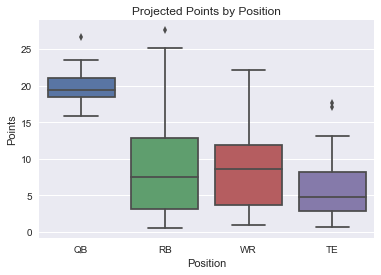

In [21]:
#Create a boxplot to compare Points across the different values for position
sns.set()
sns.boxplot(x='Position',y='Points',data=df)
plt.suptitle("") #Remove the title that is autogenerated by Pandas
plt.title('Projected Points by Position') #Add a title

Looks like the projected points among running backs are more variable than other positions. Quarterbacks have the smallest spread, ranging between 14 and 26 points. About 75% of the projected points for Tight Ends fall below 9 points.

Question 2: **Is there a correlation between salary and points?**

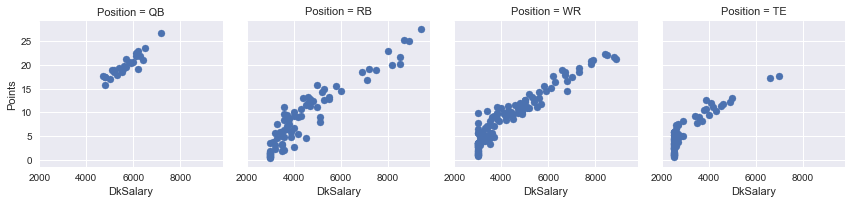

In [22]:
#Create a scatterplot to visualize the relationship between salary and points for each position
g = sns.FacetGrid(df,col='Position')
g.map(plt.scatter,'DkSalary',"Points")

There is certainly a strong positive relationship between Salary and Points. As the Salary increases the Points increase as well. In order to quantify the strength of the linear relationship we would have to compute a correlation analysis which goes beyond the scope of this project.

## 1c. Cleaning the dataset

Overall, the dataset is pretty clean. The data types are accurate, we're not missing any data, and we now have column headers that identify all of our variables. We would still like to do a few things:

- Add a column that stores the date that this information was collected
- Calculate the players expected value and insert it as a new column 

### Add columns for today's date

In [23]:
df['DateAdded']=pd.to_datetime('today').strftime("%m/%d/%Y")
df.head()

,PlayerName,DkSalary,TeamID,Position,OpponentID,Ceiling,Floor,Points,DateAdded
0,Andrew Luck,5900,IND,QB,TEN,30.96756,10.22112,20.28,11/13/2018
1,Case Keenum,4800,DEN,QB,LAC,28.97450,9.78540,17.35,11/13/2018
2,Marcus Mariota,5500,TEN,QB,IND,29.98125,9.20655,18.45,11/13/2018
3,Matthew Stafford,5400,DET,QB,CAR,28.99884,8.05737,19.23,11/13/2018
4,Cam Newton,6200,CAR,QB,DET,34.21845,11.17665,22.95,11/13/2018


### Add column that shows the players value based on their projected points

We're going to compute the H-Value for each player which is described as the following:

> H-Value combines overall value (points per dollar) and projected points in a novel formula that provides an accurate ranking of the top overall plays each week. Simply sorting the players by H-Value provides an easy ranking system, and the player with highest H-Value is the single strongest play of the week.
    -*Dan Hindrey*, [FootballGuys](https://subscribers.footballguys.com/apps/article.php?article=Draftkings_Book_H_Value_2015)

![Value](http://latex.codecogs.com/gif.latex?H_Value%20%3D%20%5Cfrac%7BPoints%20*%20%5Csqrt%7B3%7D%7D%7BSalary%7D%20*%202000)

In [24]:
#Add new column that calculates a players H_Value and print the first 5 rows

df['H_Value'] = df.Points * np.sqrt(3) / df.DkSalary * 2000
df.head()

,PlayerName,DkSalary,TeamID,Position,OpponentID,Ceiling,Floor,Points,DateAdded,H_Value
0,Andrew Luck,5900,IND,QB,TEN,30.96756,10.22112,20.28,11/13/2018,11.907115
1,Case Keenum,4800,DEN,QB,LAC,28.97450,9.78540,17.35,11/13/2018,12.521284
2,Marcus Mariota,5500,TEN,QB,IND,29.98125,9.20655,18.45,11/13/2018,11.620486
3,Matthew Stafford,5400,DET,QB,CAR,28.99884,8.05737,19.23,11/13/2018,12.336051
4,Cam Newton,6200,CAR,QB,DET,34.21845,11.17665,22.95,11/13/2018,12.822763


Let's sort our dataframe to see who the highest valued players are for this week

In [25]:
#Sort H_VALUE in descending order and print the Top 25 players for the week

df.sort_values(by='H_Value',ascending=False).head(10)

,PlayerName,DkSalary,TeamID,Position,OpponentID,Ceiling,Floor,Points,DateAdded,H_Value
6,Derek Carr,4700,OAK,QB,ARI,31.27436,10.32528,17.56,11/13/2018,12.942473
17,Deshaun Watson,5700,HOU,QB,WAS,34.69074,11.37332,21.14,11/13/2018,12.847563
9,Blake Bortles,5100,JAC,QB,PIT,29.38614,10.19249,18.91,11/13/2018,12.844345
4,Cam Newton,6200,CAR,QB,DET,34.21845,11.17665,22.95,11/13/2018,12.822763
7,Patrick Mahomes,7200,KCC,QB,LAR,42.51744,15.39792,26.64,11/13/2018,12.817176
8,Jared Goff,6100,LAR,QB,KCC,35.52356,11.58766,22.37,11/13/2018,12.703599
15,Eli Manning,5200,NYG,QB,TBB,28.11319,9.18904,18.83,11/13/2018,12.544045
16,Alex Smith,4800,WAS,QB,HOU,28.72914,9.29830,17.38,11/13/2018,12.542935
20,Drew Brees,6500,NOS,QB,PHI,36.57360,12.98304,23.52,11/13/2018,12.534718
1,Case Keenum,4800,DEN,QB,LAC,28.97450,9.78540,17.35,11/13/2018,12.521284


## 1d. Wrapping up

At this point in the project we've accomplished the following:

 - Pulled data from the web
 - Loaded the data into a DataFrame
 - Conducted exploratory data analysis
 - Taken basic steps to clean the dataset

The last step is to export the data as a flat file. In future projects I will demonstrate how to load a DataFrame directly into an existing database table.

In [26]:
#Export DataFrame to a .csv file
df.to_csv(file_name + timestr + '.csv')